In [20]:
using BenchmarkTools
using Distributed
using Plots
using ScikitLearn
using StatsBase
using HDF5, JLD
load("digits_data.jld")["data"]

In [2]:
@sk_import datasets: (fetch_covtype)

PyObject <function fetch_covtype at 0x7fd6890893a0>

In [22]:
save("digits_data.jld", "data", digits_data)


Dict{Any, Any} with 6 entries:
  "feature_names" => ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_H…
  "frame"         => nothing
  "target_names"  => ["Cover_Type"]
  "data"          => [2596.0 51.0 … 0.0 0.0; 2590.0 56.0 … 0.0 0.0; … ; 2384.0 …
  "target"        => Int32[5, 5, 2, 2, 5, 2, 5, 5, 5, 5  …  3, 3, 3, 3, 3, 3, 3…
  "DESCR"         => ".. _covtype_dataset:\n\nForest covertypes\n--------------…

In [3]:
digits_data = fetch_covtype();

In [4]:
X_digits = abs.(digits_data["data"]);
X_digits = transpose(X_digits);

In [5]:
struct NaiveGreedy
    X::Matrix{Float64}
end

struct Result
    ranking::Vector{Int32}
    gains::Vector{Float64}
end

In [6]:
function get_gains!(X, current_values, idxs, gains)
    Threads.@threads for i in eachindex(idxs)
        idx = idxs[i]
        @fastmath gains[i] = sum(sqrt.(current_values + view(X, :, idx)))
    end
end;

In [7]:
function calculate_gains!(X, gains, current_values, idxs, current_concave_value_sum)
    get_gains!(X, current_values, idxs, gains)
    
    gains .-= current_concave_value_sum
    return gains
end;

In [14]:
function fit(optimizer::NaiveGreedy, k)
    d, n = size(optimizer.X)

    cost = 0.0

    ranking = Int32[]
    total_gains = Float64[]

    mask = zeros(Int8, n)
    current_values = zeros(Float64, d)
    current_concave_values = sqrt.(current_values)
    current_concave_values_sum = sum(current_concave_values)

    idxs = 1:n

    while cost < k
        gains = zeros(Float64, size(idxs)[1])
        gains = calculate_gains!(optimizer.X, gains, current_values, idxs, current_concave_values_sum)

        idx = argmax(gains)
        best_idx = idxs[idx]
        curr_cost = 1.

        if cost + curr_cost > k
            break
        end

        cost += curr_cost
        # Calculate gains
        gain = gains[idx] * curr_cost

        # Select next
        current_values += view(optimizer.X, :, best_idx)
        current_concave_values .= sqrt.(current_values)
        current_concave_values_sum = sum(current_concave_values)

        push!(ranking, best_idx)
        push!(total_gains, gain)

        mask[best_idx] = 1
        idxs = findall(==(0), mask)
    end
    return Result(ranking, total_gains)
end;

In [15]:
k = 100;

In [16]:
opt1 = NaiveGreedy(X_digits);
res1 = @btime fit(opt1, k);

  18.016 s (116203233 allocations: 60.18 GiB)


In [11]:
opt1 = NaiveGreedy(X_digits);
res1 = @btime fit(opt1, k);
bench1 = @benchmark fit(opt1, k);
t1 = bench1.times[1]/1e9;

  16.907 s (116203315 allocations: 60.18 GiB)


In [12]:
bench0 = @benchmark begin
    idxs = StatsBase.sample(1:size(X_digits)[2], k)
    X_subset = X_digits[:, idxs]
    global gains1 = cumsum(X_subset, dims=2)
    global gains1 = vec(sum(sqrt.(gains1), dims=1))
end
t0 = bench0.times[1]/1e9;

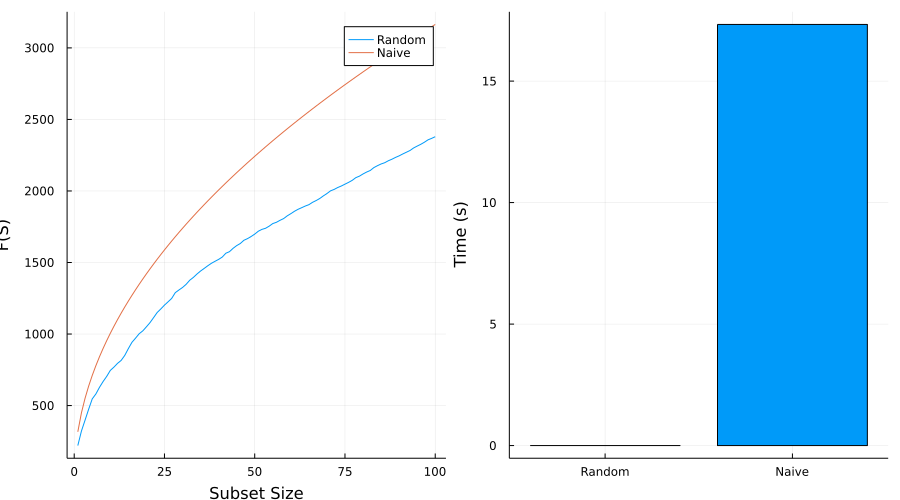

In [13]:
p1 = plot(gains1, label="Random")
plot!(cumsum(res1.gains), label="Naive")
ylabel!("F(S)", fontsize=12)
xlabel!("Subset Size", fontsize=12)

labels = ["Random", "Naive"]
p2 = bar(labels, [t0, t1], labels=labels, legend=false)
ylabel!("Time (s)")

plot(p1, p2, layout = (1, 2))
plot!(size=(900,500))